#LSA para expedientes médicos

## Paso 1: Cargar librerías y módulos requeridos



In [90]:
import pandas as pd
import numpy as np

from scipy.linalg import sqrtm
from scipy.sparse.linalg import svds #SVD estableciendo k << r

#Preprocesamiento de texto
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
nltk.download('stopwords')
nltk.download('wordnet') #WordNetLemmatizer

#Construccion de bolsas de palabras (bag of words)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [91]:
#Palabras vacías en un texto en inglés que, de ser removidas, no perdería mucho el sentido
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

##Paso 2: Definir funciones para el preprocesamiento de textos


In [92]:
#Elimina stopwords
def elimina_stopwords(texto):
  stop = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  nuevo_texto = stop.sub('', texto)
  return nuevo_texto

In [93]:
#Elimina puntuacion
def elimina_puntuacion(texto):
  nuevo_texto = re.sub('[^A-ZÜÖÄa-z0-9]+', ' ', texto)  #puntuación y todo lo que no sea letra ni números
  nuevo_texto = re.sub(" \d+", " ", nuevo_texto)   # elimina números
  return nuevo_texto

In [94]:
#Lemmatizer
lemmatizer = WordNetLemmatizer()

def lematizar(texto):
  texto=texto.split()
  nuevo_texto = " ".join([lemmatizer.lemmatize(i) for i in texto])
  return nuevo_texto

In [95]:
#Stemmmer
st = PorterStemmer()

def stemmer(texto):
  texto=texto.split()
  nuevo_texto =" ".join([st.stem(i) for i in texto])
  return nuevo_texto


In [96]:
#Preprocesar(texto)
def preprocesar(texto):
  texto = texto.lower()
  texto = elimina_stopwords(texto)
  texto = elimina_puntuacion(texto)
  texto = stemmer(texto)
  return(texto)

In [97]:
#Vectorizar texto
def vectorizar_consulta(texto):
  '''Regresa la consulta vectorizada con el mismo vocabulario que el corpus,
  y pesos tfidf en relación al corpus '''
  q = preprocesar(texto)
  q = tfidf.transform([q])
  q = q.toarray()
  return q

In [98]:
#Reducir consulta
def reducir_vec_consulta (q):
  q_k = (q @ np.transpose(Vt_k)) @ (D_k)
  return q_k


In [99]:
#Descomposición SVD
def descomposicion_k(U_k, D_k, Vt_k):
  ''' A partir de las tres matrices correspondientes a la  descomposición
  truncada en  valores singulares (donde k << r), devuelve dos matrices:
  la primera de tamaño n x k, y la segunda de dimensión k x d '''
  MDT_n_k = np.matmul(U_k, sqrtm(D_k))
  MDT_k_d = MDT_kd =  np.matmul(sqrtm(D_k), Vt_k)
  return MDT_n_k, MDT_k_d


In [100]:
#Diagnósticos similares
def documentos_similares(q_vec, M, lim = 0):
  q_vec = q_vec.flatten()
  n = M.shape[0]
  sim_coseno = {}
  relevantes={}
  #Calcular la similitud del coseno
  for i in range(n):
    sim_coseno[i] = np.dot(M[i,:], q_vec) / (np.linalg.norm(M[i,:]) * np.linalg.norm(q_vec))
    if sim_coseno[i] > lim:
      relevantes[i] = sim_coseno[i]
  if not relevantes:
    raise Exception( "No existen documentos similares", lim)

  #Ordenar valores
  relevantes_ordenados = {k:v for k, v in sorted(relevantes.items(),
                                                 key=lambda x: x[1],
                                                 reverse=True)}
  indices = list(relevantes_ordenados.keys())

  return corpus.loc[indices, :]

In [101]:
#Métricas precisión vs sensibilidad
def precision_sensibilidad(q, M, limites):
  doc_sim_dic = {}
  precision_dic = {}
  sensibilidad_dic = {}
  tolerancias_dic = {}

  for tol in limites:
    tolerancias_dic[tol] = tol
    df_similares = documentos_similares(q, M, lim = tol)
    doc_sim_dic[tol] =df_similares
    Dt = len(df_similares)                       #Documentos encontrados
    Dr = (df_similares['label']==clase_q).sum()  #Documentos relevantes encontrados
    Nr = (corpus['label']==clase_q).sum()   #Documentos relevantes en todo el corpus

    #Documentos relevantes encontrados entre todos los documentos encontrados similares
    precision_dic[tol] = Dr / Dt

    #Documentos relevantes encontrados entre todos los documentos en el corpus
    sensibilidad_dic[tol] = Dr / Nr   #Recall

  evaluacion = pd.DataFrame({'precision': precision_dic,
                           'sensibilidad': sensibilidad_dic
                           })
  evaluacion.plot.line(x= 'sensibilidad', y= 'precision',
                       title ='Precisión vs Sensibilidad',
                       xlim=(0,1), ylim=(0,1))

  plt.grid(alpha=.8, linestyle='--')
  plt.show()
  return evaluacion

## Paso 3: Cargar datos y su lectura



In [102]:
#datos = pd.read_csv('https://raw.githubusercontent.com/danieljfeller/medline-multilabel/master/data/processed/ohsumed_abstracts.csv',
#                   usecols=[0,1,2], index_col=0,)

datos = pd.read_csv('https://raw.githubusercontent.com/ElAleph25/Projectos-del-Portafolio-/main/LSAParaExpedientesM%C3%A9dicos/ohsumed_abstracts.csv',
                    usecols=[0,1,2], index_col=0)

print(datos.shape)
datos.head()

(13924, 2)


,label,doc
0,16,Improved outcome at 28 days of age for very l...
1,5,Chylothorax after posterior spinal instrument...
2,16,Childhood pulmonary function following hyalin...
3,8,Treatment of atelectasis of upper lung lobes....
4,21,"Decision analysis, public health policy, and ..."


In [103]:
#Podemos revisar los diagnósticos médicos individualmente
datos.loc[0,'doc']

' Improved outcome at 28 days of age for very low birth weight infants treated with a single dose of a synthetic surfactant, Two identical double-blind. controlled. randomized trials were initiated to determine whether the administration of a single 5 ml/kg dose of a synthetic surfactant (Exosurf Neonatal). soon after the delivery of infants with birth weights 700 to 1350 gm. would improve rates of survival without bronchopulmonary dysplasia. Both trials were terminated before enrolling their planned sample sizes because of the availability of Exosurf under the provisions of a Treatment Investigational New Drug program. We report the combined results of these trials. Study infants were stratified according to birth weight and gender before random assignment to a treatment regimen. One hundred ninety-two infants received Exosurf and 193 received an air placebo. The study groups were similar when a variety of demographic features describing the mothers. their pregnancies. the circumstanc

In [104]:
#¿En cuántas categorías están catalogados los documentos?
len(datos['label'].value_counts())


23

##Paso 4: Separar el corpus para tener documentos de consulta

In [105]:
datos.sample(10, random_state=3)

,label,doc
5832,18,Alkaline phosphatase (tissue-nonspecific isoe...
12535,10,The community hospital-based stroke programs ...
151,23,Surgery in patients on long-term steroid ther...
11997,4,Primary Ewing sarcoma: follow-up with Ga-67 s...
13010,21,Psychiatric diagnoses of treatment-seeking co...
3077,21,Clinical experience with the benzodiazepine a...
10659,23,The validity of canine platelet aggregometry ...
965,6,Evaluation of women with possible appendiciti...
8664,14,Heart rate adjustment of exercise-induced ST ...
6687,14,"Auto-PEEP during CPR. An ""occult"" cause of el..."


In [106]:
#Separamos una muestra aleatoria de 10 documentos, que serán nuestras consultas
consultas_idx = datos.sample(10, random_state=3).index
consultas = datos.iloc[consultas_idx,:].copy()
consultas

,label,doc
5832,18,Alkaline phosphatase (tissue-nonspecific isoe...
12535,10,The community hospital-based stroke programs ...
151,23,Surgery in patients on long-term steroid ther...
11997,4,Primary Ewing sarcoma: follow-up with Ga-67 s...
13010,21,Psychiatric diagnoses of treatment-seeking co...
3077,21,Clinical experience with the benzodiazepine a...
10659,23,The validity of canine platelet aggregometry ...
965,6,Evaluation of women with possible appendiciti...
8664,14,Heart rate adjustment of exercise-induced ST ...
6687,14,"Auto-PEEP during CPR. An ""occult"" cause of el..."


In [107]:
#Dejamos el resto de los documentos como nuestro corpus
corpus = pd.concat([datos,consultas]).drop_duplicates(keep=False).reset_index(drop=True)
consultas = consultas.reset_index(drop=True)
print(corpus.shape)
corpus

(13914, 2)


,label,doc
0,16,Improved outcome at 28 days of age for very l...
1,5,Chylothorax after posterior spinal instrument...
2,16,Childhood pulmonary function following hyalin...
3,8,Treatment of atelectasis of upper lung lobes....
4,21,"Decision analysis, public health policy, and ..."
...,...,...
13909,11,Results of blepharoptosis surgery with early ...
13910,11,"A century of cerebral achromatopsia, This rev..."
13911,11,Intraocular lens implantation after penetrati...
13912,11,Reproducibility of topographic measurements o...


In [108]:
consultas

,label,doc
0,18,Alkaline phosphatase (tissue-nonspecific isoe...
1,10,The community hospital-based stroke programs ...
2,23,Surgery in patients on long-term steroid ther...
3,4,Primary Ewing sarcoma: follow-up with Ga-67 s...
4,21,Psychiatric diagnoses of treatment-seeking co...
5,21,Clinical experience with the benzodiazepine a...
6,23,The validity of canine platelet aggregometry ...
7,6,Evaluation of women with possible appendiciti...
8,14,Heart rate adjustment of exercise-induced ST ...
9,14,"Auto-PEEP during CPR. An ""occult"" cause of el..."


El objetivo es comparar estas 10 consultas contra los documentos del corpus y ver a cuál se parece más.

##Paso 5: Preprocesamiento de texto



Los pasos clásicos en el preprocesamiento de textos
en el $\textit{Procesamiento del Lenguaje Natural}$ son:

- Convertir palabras a minúsculas.
- Quitar $\textit{stopwords}$.
- Quitar puntuación.
- Quitar números.
- Quitar espacios en blanco.

Normalizar un texto, consiste en realizar la técnica de $\textit{lematización}$ o $\textit{stemming}$ (radicalización) en los textos.

Referencia:
https://towardsdatascience.com/introduction-to-nlp-part-2-difference-between-lemmatisation-and-stemming-3789be1c55bc




###Ejemplo
Se hará un ejemplo particular de la aplicación de las funciones recurrentes en el procesamiento de texto.

In [109]:
#Elegimos un texto del corpus
ejemplo = np.random.choice(corpus['doc'])
print(len(ejemplo))
ejemplo

1122


' Possible significance of cilioretinal arteries in low-tension glaucoma, Cilioretinal arteries arise from the short posterior ciliary artery circulation or directly from the choroidal circulation. The presence of a cilioretinal artery may in compromised discs steal flow from the peripapillary circulation and account for worsening glaucoma damage. We reviewed the records of 33 patients with unilateral cilioretinal arteries admitted for investigation of low-tension glaucoma. We looked for absolute difference between the affected and unaffected eyes as well as percent difference relative to the mean value for the two eyes and to the value for the unaffected eye in the following variables: mean defect. corrected loss variance or corrected pattern standard deviation. and adjusted neuroretinal rim area. No statistically significant differences were found. The mean disc area for the eyes with cilioretinal arteries was significantly larger than that previously reported for normal eyes. The re

In [110]:
#Se transforma el texto a minúsculas
ejemplo = ejemplo.lower()
print(len(ejemplo))
ejemplo


1122


' possible significance of cilioretinal arteries in low-tension glaucoma, cilioretinal arteries arise from the short posterior ciliary artery circulation or directly from the choroidal circulation. the presence of a cilioretinal artery may in compromised discs steal flow from the peripapillary circulation and account for worsening glaucoma damage. we reviewed the records of 33 patients with unilateral cilioretinal arteries admitted for investigation of low-tension glaucoma. we looked for absolute difference between the affected and unaffected eyes as well as percent difference relative to the mean value for the two eyes and to the value for the unaffected eye in the following variables: mean defect. corrected loss variance or corrected pattern standard deviation. and adjusted neuroretinal rim area. no statistically significant differences were found. the mean disc area for the eyes with cilioretinal arteries was significantly larger than that previously reported for normal eyes. the re

In [111]:
#Se elimina puntuación
ejemplo = elimina_puntuacion(ejemplo)
print(len(ejemplo))
ejemplo


1109


' possible significance of cilioretinal arteries in low tension glaucoma cilioretinal arteries arise from the short posterior ciliary artery circulation or directly from the choroidal circulation the presence of a cilioretinal artery may in compromised discs steal flow from the peripapillary circulation and account for worsening glaucoma damage we reviewed the records of  patients with unilateral cilioretinal arteries admitted for investigation of low tension glaucoma we looked for absolute difference between the affected and unaffected eyes as well as percent difference relative to the mean value for the two eyes and to the value for the unaffected eye in the following variables mean defect corrected loss variance or corrected pattern standard deviation and adjusted neuroretinal rim area no statistically significant differences were found the mean disc area for the eyes with cilioretinal arteries was significantly larger than that previously reported for normal eyes the results sugges

In [112]:
#Se eliminan las "palabras irrelevantes"
ejemplo = elimina_stopwords(ejemplo)
print(len(ejemplo))
ejemplo

862


' possible significance cilioretinal arteries low tension glaucoma cilioretinal arteries arise short posterior ciliary artery circulation directly choroidal circulation presence cilioretinal artery may compromised discs steal flow peripapillary circulation account worsening glaucoma damage reviewed records patients unilateral cilioretinal arteries admitted investigation low tension glaucoma looked absolute difference affected unaffected eyes well percent difference relative mean value two eyes value unaffected eye following variables mean defect corrected loss variance corrected pattern standard deviation adjusted neuroretinal rim area statistically significant differences found mean disc area eyes cilioretinal arteries significantly larger previously reported normal eyes results suggest vascular steal exists presence artery major clinical importance '

In [113]:
#Ejemplo de diferencia entre lematización y stemización (radicalización)
oracion = 'i have one foot and two feet constitutional'
print(lematizar(oracion))
print(stemmer(oracion))

i have one foot and two foot constitutional
i have one foot and two feet constitut


In [114]:
ejemplo_lema = lematizar(ejemplo)
print(len(ejemplo_lema))
ejemplo_lema

842


'possible significance cilioretinal artery low tension glaucoma cilioretinal artery arise short posterior ciliary artery circulation directly choroidal circulation presence cilioretinal artery may compromised disc steal flow peripapillary circulation account worsening glaucoma damage reviewed record patient unilateral cilioretinal artery admitted investigation low tension glaucoma looked absolute difference affected unaffected eye well percent difference relative mean value two eye value unaffected eye following variable mean defect corrected loss variance corrected pattern standard deviation adjusted neuroretinal rim area statistically significant difference found mean disc area eye cilioretinal artery significantly larger previously reported normal eye result suggest vascular steal exists presence artery major clinical importance'

In [115]:
ejemplo_stem = stemmer(ejemplo)
print(len(ejemplo_stem))
ejemplo_stem

725


'possibl signific cilioretin arteri low tension glaucoma cilioretin arteri aris short posterior ciliari arteri circul directli choroid circul presenc cilioretin arteri may compromis disc steal flow peripapillari circul account worsen glaucoma damag review record patient unilater cilioretin arteri admit investig low tension glaucoma look absolut differ affect unaffect eye well percent differ rel mean valu two eye valu unaffect eye follow variabl mean defect correct loss varianc correct pattern standard deviat adjust neuroretin rim area statist signific differ found mean disc area eye cilioretin arteri significantli larger previous report normal eye result suggest vascular steal exist presenc arteri major clinic import'

### Preprocesamiento de todo el corpus

Finalmente, se hará el procesamiento anterior en todo el corpus.

In [116]:
%%time
corpus['doc_pp'] = corpus['doc'].apply(preprocesar)

CPU times: user 43.7 s, sys: 522 ms, total: 44.2 s
Wall time: 44.6 s


In [117]:
corpus.head()

,label,doc,doc_pp
0,16,Improved outcome at 28 days of age for very l...,improv outcom day age low birth weight infant ...
1,5,Chylothorax after posterior spinal instrument...,chylothorax posterior spinal instrument fusion...
2,16,Childhood pulmonary function following hyalin...,childhood pulmonari function follow hyalin mem...
3,8,Treatment of atelectasis of upper lung lobes....,treatment atelectasi upper lung lobe select br...
4,21,"Decision analysis, public health policy, and ...",decis analysi public health polici isoniazid c...


##Paso 6: Bolsas de palabras y TF-IDF



Se usará la funcion **```TFidfVectorizer```** de sklearn. Notar que, el paramentro **```min_df```**, hace la función "cut-off" para no considerar los términos con poca frecuencia en el documento. En este ejercio, se ha establecido una frecuencia de al menos 70 documentos que contengan el término que corresponde a cerca del 0.5% de todos los documentos.

In [118]:
tfidf = TfidfVectorizer(min_df=30)
mdt_tfidf = tfidf.fit_transform(corpus['doc_pp'])
palabras = tfidf.get_feature_names_out()
MDT = pd.DataFrame(mdt_tfidf.todense(),
                              index=corpus.index,
                              columns=palabras)
print(MDT.shape)
MDT #Matriz Documento Término

(13914, 3418)


,a2,ab,abdomen,abdomin,aberr,abil,abl,ablat,abnorm,abolish,...,year,yet,yield,york,young,younger,yr,zero,zidovudin,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.068062,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.144747,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.041414,0.0,0.0,0.0,0.079649,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
13910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
13911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
13912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [119]:
#¿Qué porcentaje de celdas tienen cero?

no_ceros = MDT.astype(bool).sum().sum()  #Cantidad de ceros en todo el dataframe
total = MDT.shape[0] * MDT.shape[1]

(1- no_ceros/total) * 100



98.27187412974779

##Paso 7: Descomposición SVD con Numpy     

Sea $X$ una matriz de $N\times d$. La descomposición singular de $X$, se define como el producto $$X=UDV^T,$$ donde $D$ es alguna matriz diagonal con entradas que satisfacen $0<\delta_r\leq\dots\leq\delta_1$. Estos valores son las raíces cuadradas de los autovalores de la matriz $XX^T$. Estos son los $\textit{valores singulares}$ de $X$.

In [120]:
#Obtendremos la descomposición SVD
%%time
#Descomposición de la Matriz Documento Término  (3 min)
U_, sigma_, Vt_ = np.linalg.svd(MDT)

#Obtener con los valores singulares (sigma) la matriz diagonal D
D_ = np.diag(sigma_)

#Ver las dimensiones de las tres matrices
print(U_.shape, D_.shape, Vt_.shape)


(13914, 13914) (3418, 3418) (3418, 3418)
CPU times: user 5min 6s, sys: 19.4 s, total: 5min 26s
Wall time: 3min 17s


In [121]:
sigma_.shape

(3418,)

In [122]:
#¿Cuántos valores de sigma son distintos de cero?
sigmas = sigma_[np.nonzero(sigma_)]
len(sigmas)


3418

In [123]:
min(sigma_)

#Esto implica que la matriz MDT es no singular

2.831030846990451e-15

In [124]:
#En el vector sigma estan ordenados los eigenvalores
sigma_


array([2.05277892e+01, 1.08854544e+01, 1.00154438e+01, ...,
       3.48546149e-01, 3.31332609e-01, 2.83103085e-15])

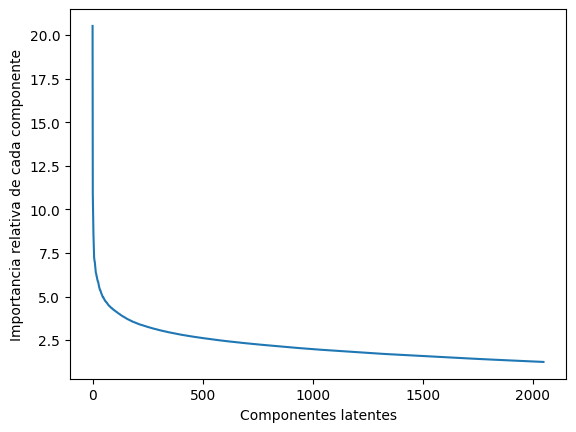

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 2049
sns.lineplot(x=list(range(len(sigma_[0:k]))), y = sigma_[0:k])
plt.ylabel('Importancia relativa de cada componente')
plt.xlabel('Componentes latentes')
plt.show()



##Paso 8: Análisis semántico latente (LSA)


Vamos a explicar el algoritmo.

1. Sea $X$ una matrix con $N$ renglones y $d$ columnas (comúnmente, $N$ denota los registros de un DataSet y $d$ las features de un DataSet).

2. Calculemos su descomposición en valores singulares, $X=UDV^T$, donde $U$ es una matriz de $N\times r$ , $D$ una matriz de $r\times r$
y $V$ una matriz de $d\times r$.

3. Fijemos un $k\leq r$ que será la dimensión de nuestro espacio latente.

4. Sea $D_k$ la matriz con los k valores singulares más grandes.

5. Sea $U_k$ la matriz de $N\times k$ con las primeras $k$ columnas.

6. Sea $V_k$ la matriz de $d\times k$ con las primeras $k$ columnas ; es decir, los
primeros $k$ renglones de $V^T$.

7. La matriz $U_kD_kV_k^T$
es una aproximación de la matriz original $X$ tal que su rango ha disminuido, es decir es igual a $k$.

El objetivo del algoritmo, entonces, será calcular el anterior producto.

In [126]:
%%time
#from scipy.sparse.linalg import svds
U_k, sigmas_k, Vt_k = svds(np.array(MDT), k=100)
D_k = np.diag(sigmas_k)

CPU times: user 48.9 s, sys: 5.57 s, total: 54.5 s
Wall time: 32.9 s


In [127]:
#Matriz documentos-temas / Matriz relevancia temas / Matriz temas-documentos

U_k.shape, D_k.shape, Vt_k.shape


((13914, 100), (100, 100), (100, 3418))

Obtengamos la matriz $\textit{reducida LSA}$ que representa a cada documento con $k$ términos.

Para ello, realizaremos la operación $$X_{N\times k}=U_k\sqrt{D_k}.$$

In [128]:
X1 = np.matmul(U_k, sqrtm(D_k))
X1.shape

(13914, 100)

Obtendremos la matriz $\textit{reducida LSA}$ que representa a cada palabra con $k$ términos.

Para esto, realizaremos la operación $$X_{k\times d}=\sqrt{D_k}V_k^T.$$


In [129]:
X2 =  np.matmul(sqrtm(D_k), Vt_k)
X2.shape

(100, 3418)

La función **```descomposicion_k()```** regresa las dos matrices obtenidas en las líneas anteriores.

In [130]:
MDT_nk, MDT_kd = descomposicion_k(U_k, D_k, Vt_k )

print(MDT_nk.shape, MDT_kd.shape)

(13914, 100) (100, 3418)


In [131]:
#Renglones reducidos y columnas reducidas
(X1).shape, np.transpose(X2).shape

((13914, 100), (3418, 100))

##Paso 9: Vectorizar consulta (texto nuevo)



Vamos a vectorizar nuestra consulta utilizando el mismo vocabulario que en el corpus.

###Ejemplo

Vamos a usar cualquier texto.

In [132]:
q = vectorizar_consulta('heart desease')
q.shape

(1, 3418)

In [133]:
#Forma del vector q
q

array([[0., 0., 0., ..., 0., 0., 0.]])

In [134]:
#Forma de la matriz D_k
D_k

array([[ 4.2031701 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  4.21587919,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  4.22501491, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 10.01544382,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        10.88545435,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 20.52778921]])

Tenemos la consulta con las $d=3418$ dimensiones que corresponden al vocabulario del corpus.

Por lo tanto, es necesario reducir la dimensionalidad del vector $q$ usando las matrices $D_k$ y $V_k$.

Para ello, se hará la operación $$q_k=qV_kD_k.$$


In [135]:
q_k = (q @ np.transpose(Vt_k)) @ (D_k)
print(q.shape, np.transpose(Vt_k).shape, D_k.shape )
print(q_k.shape)


(1, 3418) (3418, 100) (100, 100)
(1, 100)


In [136]:
#Forma de q_k
q_k

array([[ 0.30272138, -0.56578382, -0.14752191, -0.10116832,  0.155483  ,
        -0.01228598,  0.09919797, -0.1709579 , -0.17588541, -0.28315628,
         0.32163991, -0.39199148,  0.06391857,  0.38156753, -0.14419347,
         0.30015375, -0.00207211,  0.33914105,  0.14466671,  0.06316403,
        -0.47086308,  0.37760782, -0.33982434, -0.42633538, -0.38554188,
         0.00634079,  0.49979817,  0.26798823, -0.55923868, -0.23561511,
         0.05886883, -0.23148801,  0.1365941 , -0.09219835,  0.63849417,
         0.04807855, -0.39745537,  0.5002584 , -0.22179374, -0.06400388,
         0.33445774, -0.06588183, -0.34939202, -0.31601499, -0.62905569,
         0.57649977, -0.13828977, -0.11005103,  0.03922574, -0.13470814,
         0.01078751,  0.40388893,  0.24954096,  0.1802562 , -0.14737128,
        -0.41890636, -0.35537966,  0.0641585 , -0.2696979 ,  0.17495785,
         0.04699558, -0.16369791, -0.03965863,  0.16175557, -0.45363026,
         0.1272669 ,  0.02241711,  0.08475085, -0.2

El código anterior se resume en la función  **```reducir_vec_consulta()```**.

In [137]:
q_k = reducir_vec_consulta(q)
q_k.shape

(1, 100)

###Vectorizar consultas

Vamos a repetir el proceso anterior con nuestras consultas de interés.

In [138]:
#Recordemos que tenemos 10 consultas
consultas

,label,doc
0,18,Alkaline phosphatase (tissue-nonspecific isoe...
1,10,The community hospital-based stroke programs ...
2,23,Surgery in patients on long-term steroid ther...
3,4,Primary Ewing sarcoma: follow-up with Ga-67 s...
4,21,Psychiatric diagnoses of treatment-seeking co...
5,21,Clinical experience with the benzodiazepine a...
6,23,The validity of canine platelet aggregometry ...
7,6,Evaluation of women with possible appendiciti...
8,14,Heart rate adjustment of exercise-induced ST ...
9,14,"Auto-PEEP during CPR. An ""occult"" cause of el..."


In [139]:
#Elegiremos aleatoriamente uno de los diagnósticos como consulta.
#En este caso, elegimos el documento 1.
#Guardamos la clase y el texto.

q_idx = 1
clase_q =consultas.loc[q_idx,'label']
Q = consultas.loc[q_idx,'doc']

print('Clase de la consulta:' , clase_q,'\n')
Q


Clase de la consulta: 10 



' The community hospital-based stroke programs in North Carolina, Oregon and New York--V. Stroke diagnosis: factors influencing the diagnostic evaluation of patients following acute stroke, Among the 4129 patients of the Community Hospital-based Stroke Program. 30% had an unspecified stroke diagnosis. Since specific diagnosis and. perhaps. eventual treatment. derives in part from diagnostic testing. we examined the effect of clinical condition. geographic and demographic factors on the incidence of certain diagnostic tests after acute stroke. In this multivariable analysis. race. sex. history of hypertension and history of diabetes did not influence the chance of having any test. but older age strongly reduced the chances of receiving extensive evaluation. When CT scanning was available. the utilization of a CT as well as other diagnostic studies including cerebral angiography. radionuclide brain scan. EEG and EKG was increased. The odds of receiving a CT scan increased if the patient 

Vectorizemos este texto.

In [140]:
q = vectorizar_consulta(Q)  #Preprocesar y vectorizar
q_k = reducir_vec_consulta(q)  #Reducir a k dimensiones
print ('Dimensión vector q  :', q.shape)
print ('Dimensión vector q_k:', q_k.shape)

Dimensión vector q  : (1, 3418)
Dimensión vector q_k: (1, 100)


##Paso 10: Obtener documentos relevantes a la consulta

In [141]:
tol = .2  #Valor a partir del que se considera un documento similar a la consulta, el limite o threshold

doc_sim = documentos_similares(q_k, MDT_nk, lim = tol)


Dt = len(doc_sim)                       #Documentos encontrados
Dr = (doc_sim['label']==clase_q).sum()  #Documentos relevantes encontrados
Nr = (corpus['label']==clase_q).sum()   #Documentos relevantes en todo el corpuss

#Documentos relevantes encontrados entre todos los documentos encontrados similares
precision = Dr / Dt

#Documentos relevantes encontrados entre todos los documentos relevantes en el corpus
sensibilidad = Dr / Nr   #Recall

print ('                 Documentos encontrados: ', Dt)
print ('      Documentos relevantes encontrados: ', Dr)
print ('Documentos relevantes en todo el corpus: ', Nr, '\n')

print ('                              Precisión: {:1.2f}'.format(precision))
print ('                           Sensibilidad: {:1.2f}'.format(sensibilidad))

                 Documentos encontrados:  4784
      Documentos relevantes encontrados:  708
Documentos relevantes en todo el corpus:  1221 

                              Precisión: 0.15
                           Sensibilidad: 0.58


In [142]:
tol = .2  #Valor a partir del que se considera un documento similar a la consulta

doc_sim = documentos_similares(q, MDT.to_numpy(), lim = tol)


Dt = len(doc_sim)                       #Documentos encontrados
Dr = (doc_sim['label']==clase_q).sum()  #Documentos relevantes encontrados
Nr = (corpus['label']==clase_q).sum()   #Documentos relevantes en todo el corpus

#Documentos relevantes encontrados entre todos los doc encontrados similares
precision = Dr / Dt

#Documentos relevantes encontrados entre todos los docrelevantes en el corpus
sensibilidad = Dr / Nr   #Recall

print ('                 Documentos encontrados: ', Dt)
print ('      Documentos relevantes encontrados: ', Dr)
print ('Documentos relevantes en todo el corpus: ', Nr, '\n')

print ('                              Precisión: {:1.2f}'.format(precision))
print ('                           Sensibilidad: {:1.2f}'.format(sensibilidad))

                 Documentos encontrados:  43
      Documentos relevantes encontrados:  30
Documentos relevantes en todo el corpus:  1221 

                              Precisión: 0.70
                           Sensibilidad: 0.02


Finalmente, aquí están los documentos del corpus similares a la consulta 1.

In [143]:
doc_sim

,label,doc,doc_pp
3860,10,Emergence of recreational drug abuse as a maj...,emerg recreat drug abus major risk factor stro...
8949,10,"The frequency, causes and timing of death wit...",frequenc caus time death within day first stro...
3483,23,Circadian variation in onset of acute ischemi...,circadian variat onset acut ischem stroke circ...
5147,10,Mechanism of stroke in patients taking aspiri...,mechan stroke patient take aspirin year period...
2543,20,Stroke in systemic lupus erythematosus [publi...,stroke system lupu erythematosu publish erratu...
8543,10,Life events and difficulties preceding stroke...,life event difficulti preced stroke life event...
5322,10,Community hospital carotid endarterectomy in ...,commun hospit carotid endarterectomi patient a...
8225,10,"Hypertension, cigarette smoking, and the decl...",hypertens cigarett smoke declin stroke incid e...
9857,10,The stroke syndrome of striatocapsular infarc...,stroke syndrom striatocapsular infarct striato...
3418,18,The influence of hyperglycemia and diabetes m...,influenc hyperglycemia diabet mellitu immedi m...


Podemos revisar individualmente los documentos similares a la consulta 1 y compararlos.

In [144]:
doc_sim.loc[3860]['doc']

' Emergence of recreational drug abuse as a major risk factor for stroke in young adults, OBJECTIVE: To investigate the clinical and epidemiologic relations between recreational drug abuse and stroke in young persons. DESIGN: A case-control study based on medical records. SETTING: San Francisco General Hospital. a 400-bed municipal hospital. PATIENTS: Consecutive sample of 214 patients aged 15 to 44 years. admitted between 1979 and 1988 with a diagnosis of ischemic or hemorrhagic stroke. An equal number of control patients admitted with diagnoses of status asthmaticus. acute appendicitis. or acute cholecystitis were matched to stroke patients by age. sex. and year of hospitalization. MEASUREMENTS AND MAIN RESULTS: Seventy-three patients with stroke (34%) were drug abusers compared with 18 (8%) of the controls. In 47 patients with stroke. temporal proximity of drug administration (n = 34) or infectious endocarditis (n = 13) suggested a direct association between drug abuse and stroke. A

In [145]:
#Documento 1 de la consulta
Q

' The community hospital-based stroke programs in North Carolina, Oregon and New York--V. Stroke diagnosis: factors influencing the diagnostic evaluation of patients following acute stroke, Among the 4129 patients of the Community Hospital-based Stroke Program. 30% had an unspecified stroke diagnosis. Since specific diagnosis and. perhaps. eventual treatment. derives in part from diagnostic testing. we examined the effect of clinical condition. geographic and demographic factors on the incidence of certain diagnostic tests after acute stroke. In this multivariable analysis. race. sex. history of hypertension and history of diabetes did not influence the chance of having any test. but older age strongly reduced the chances of receiving extensive evaluation. When CT scanning was available. the utilization of a CT as well as other diagnostic studies including cerebral angiography. radionuclide brain scan. EEG and EKG was increased. The odds of receiving a CT scan increased if the patient 

##Paso 11: Evaluación de la recuperación de información

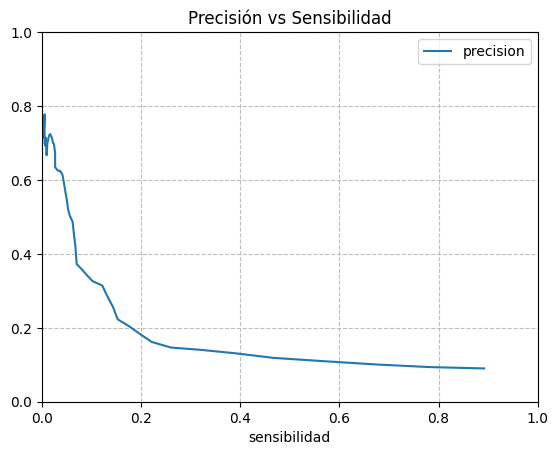

In [146]:
tols = np.linspace(0.01, 0.3,50)
evaluacion = precision_sensibilidad(q, MDT.to_numpy(),tols)


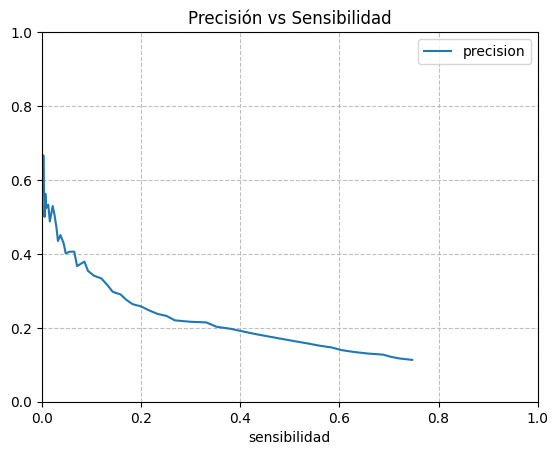

In [147]:
tols = np.linspace(0.15, 0.49, 50)
evaluacion_k = precision_sensibilidad(q_k, MDT_nk, tols)
